<a href="https://colab.research.google.com/github/Prasadchaskar/Blood-Cells-Classification/blob/main/BloodCellsClassf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np 

In [34]:
BATCH_SIZE = 32
IMAGE_SIZE1 = 320
IMAGE_SIZE2 = 240
CHANNELS=3
EPOCHS=10

In [35]:
# import zipfile
# !unzip /content/sample_data/TRAIN.zip

**Load Data**

In [36]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/TRAIN",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE1,IMAGE_SIZE2),
    batch_size=BATCH_SIZE
)

Found 1991 files belonging to 4 classes.


In [37]:
class_names = dataset.class_names

**Show some Images from dataset**

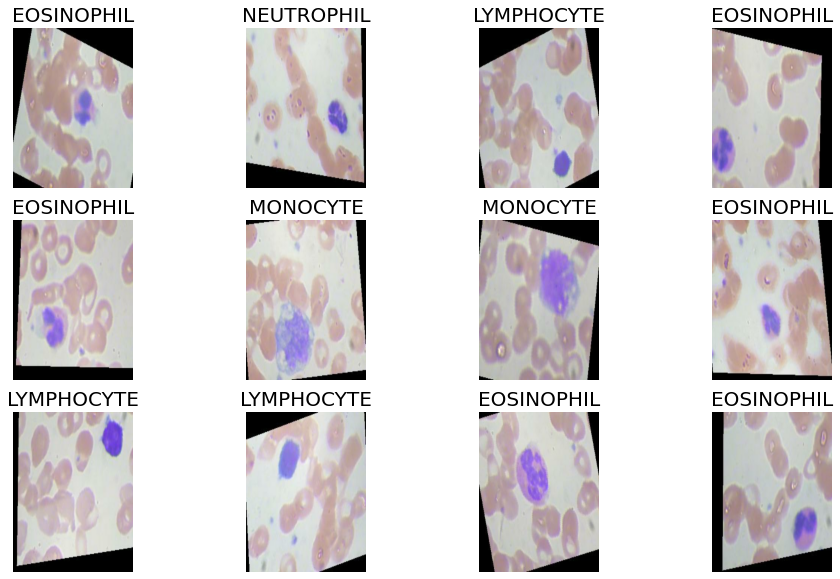

In [38]:
plt.figure(figsize=(16,10))
for img,lbl in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[lbl[i]],{'fontsize':20})
        plt.axis("off")

In [39]:
len(dataset)

63

**Split Data**

In [40]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [41]:
train_data,valid_data,test_data = get_dataset_partitions_tf(dataset)

In [42]:
print(len(train_data),len(test_data))

44 13


In [43]:
train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = valid_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [45]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Creatation**

In [46]:
input_shape = (BATCH_SIZE, IMAGE_SIZE1, IMAGE_SIZE2, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [47]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

**Train Model**

In [51]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=25
)

Epoch 1/25
44/44 [==============================] - 16s 367ms/step - loss: 0.5677 - accuracy: 0.7397 - val_loss: 0.4744 - val_accuracy: 0.7425
Epoch 2/25
44/44 [==============================] - 16s 367ms/step - loss: 0.5475 - accuracy: 0.7411 - val_loss: 0.4666 - val_accuracy: 0.8144
Epoch 3/25
44/44 [==============================] - 16s 373ms/step - loss: 0.5079 - accuracy: 0.7599 - val_loss: 0.4131 - val_accuracy: 0.8084
Epoch 4/25
44/44 [==============================] - 16s 364ms/step - loss: 0.5090 - accuracy: 0.7484 - val_loss: 0.4821 - val_accuracy: 0.7784
Epoch 5/25
44/44 [==============================] - 16s 367ms/step - loss: 0.5326 - accuracy: 0.7628 - val_loss: 0.4047 - val_accuracy: 0.8383
Epoch 6/25
44/44 [==============================] - 16s 366ms/step - loss: 0.5195 - accuracy: 0.7534 - val_loss: 0.3984 - val_accuracy: 0.8383
Epoch 7/25
44/44 [==============================] - 16s 368ms/step - loss: 0.5208 - accuracy: 0.7614 - val_loss: 0.4253 - val_accuracy: 0.8084

In [52]:
 model.evaluate(test_data)

13/13 [==============================] - 4s 54ms/step - loss: 0.4105 - accuracy: 0.7981


[0.4104854166507721, 0.7980769276618958]

**Accuracy Curves**

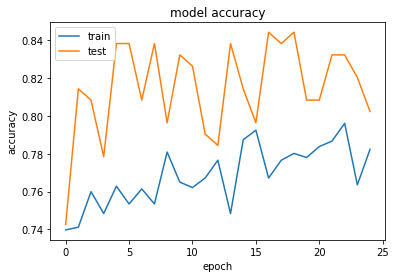

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

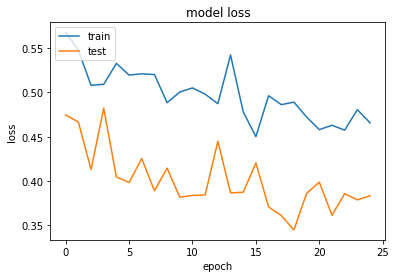

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
# from keras.models import load_model
# my_model = load_model('/content/model.h5')
class_names = [0,1,2,3]
y_pred = list()
for img,labl in test_data:
  for i in range(len(test_data)):
    img_array = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    y_pred.append(predicted_class)

In [66]:
y_true  = list()
for img,labl in test_data:
  for i in range(len(test_data)):
    y_true.append(lbl[i].numpy())

**Classifiaction Report**

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.37      0.22      0.27        78
           1       0.20      0.26      0.22        39
           2       0.21      0.18      0.19        39
           3       0.05      0.15      0.08        13

    accuracy                           0.21       169
   macro avg       0.21      0.20      0.19       169
weighted avg       0.27      0.21      0.23       169



**Confusion** **Matrix**

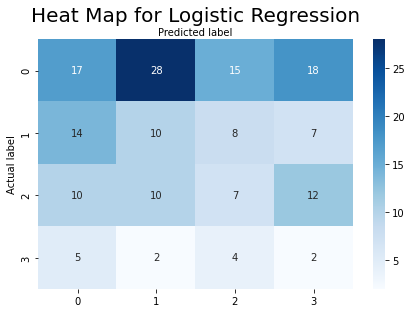

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd 
class_names = [0,1,2,3]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

cnf_matrix = confusion_matrix(y_true,y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Blues',
            fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title(f'Confusion Matrix', {'fontsize':20})
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

**Save Model**

In [64]:
model.save('model.h5')